# Implementation of clustering algorithms

Build K-Means and Agglomerative Clustering models to perform an unsupervised clustering by using given data. Follow below steps as a guideline for building your model and explain each of them in code lines. 

* Data cleaning 

Start with data cleaning to ensure that your data is correct, consistent and usable. The techniques used for data cleaning may vary but you can consider to follow these basic steps: handling missing values, encoding categorical features, extracting useful features by using existing features, handling outliers etc.

* Data Preprocessing

In this step you should transform raw data into an understandable format for machine learning algorithms. This step may include scaling the features, performing dimensionality reduction etc.

* Clustering 

The goal of this step is to find distinct groups or “clusters” within a data set by using K-Means and Agglomerative Clustering Algorithms. Apply Elbow Method to determine the number of clusters. After building models, examine and comment the clusters formed via scatter plot.

* Silhouette Scores 

To evaluate how “well clustered” data points are, use the “silhouette score” and plot the Silhouette Scores for all of data points.

Note: Don't forget to explain your codes and comment on the obtained result.

In [1]:
# Importing libraries that may be necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# Reading data and check if it has any missing values
df = pd.read_csv('dataset.csv')
if df.isnull().values.any() == False: print("There is no missing values in this dataset.")
df

There is no missing values in this dataset.


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [2]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<AxesSubplot:>

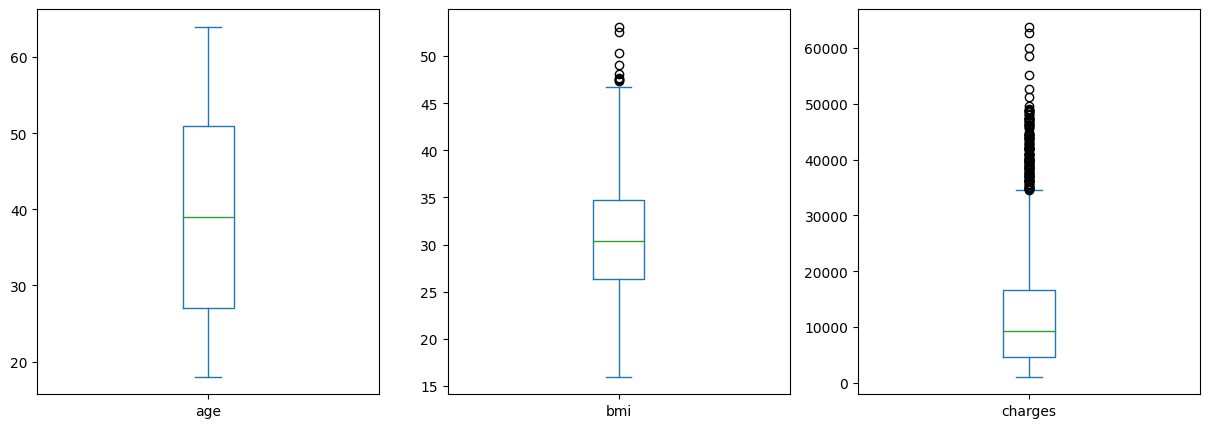

In [3]:
# Converting categorical features to numerical
df = df.replace(to_replace = ['female', 'male'], value = [0, 1])
df = df.replace(to_replace = ['no', 'yes'], value = [0, 1])
df = df.replace(to_replace = ['northwest', 'northeast', 'southwest', 'southeast'], value = [1, 2, 3, 4])

# Looking for outliers
fig, ax = plt.subplots(1,3, figsize = (15,5))
df.plot(kind = 'box', y = 'age', ax = ax[0])
df.plot(kind = 'box', y = 'bmi', ax = ax[1])
df.plot(kind = 'box', y = 'charges', ax = ax[2])

In [4]:
# Removing outliers
df = df.loc[df['bmi'] < 50]
df = df.loc[df['charges'] < 55000]

# Scaling features
scaler = StandardScaler()
df[['s_age', 's_sex', 's_bmi', 's_children', 's_smoker', 's_region', 's_charges']] = scaler.fit_transform(
    df[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']])
scaled_df = df[['s_age', 's_sex', 's_bmi', 's_children', 's_smoker', 's_region', 's_charges']]
scaled_df

,s_age,s_sex,s_bmi,s_children,s_smoker,s_region,s_charges
0,-1.440545,-1.009064,-0.448054,-0.909592,1.990650,0.406367,0.322934
1,-1.511740,0.991018,0.529409,-0.080423,-0.502349,1.292380,-0.966543
2,-0.799791,0.991018,0.401190,1.577914,-0.502349,1.292380,-0.734844
3,-0.443817,0.991018,-1.313117,-0.909592,-0.502349,-1.365659,0.756708
4,-0.515012,0.991018,-0.284866,-0.909592,-0.502349,-1.365659,-0.784401
...,...,...,...,...,...,...,...
1333,0.766496,0.991018,0.063157,1.577914,-0.502349,-1.365659,-0.211624
1334,-1.511740,-1.009064,0.221350,-0.909592,-0.502349,-0.479646,-0.925677
1335,-1.511740,-1.009064,1.042286,-0.909592,-0.502349,1.292380,-0.974685
1336,-1.298155,-1.009064,-0.797743,-0.909592,-0.502349,0.406367,-0.942523


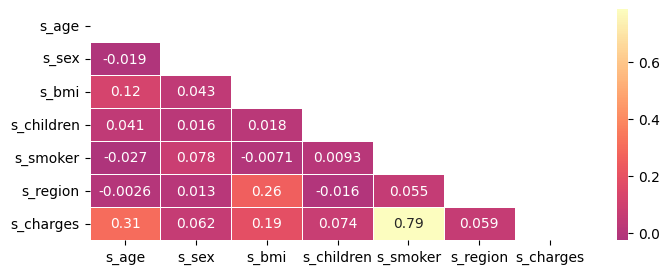

In [5]:
# Analyzing the correlations between features to extract useful features
plt.subplots(figsize=(8, 3))
sns.heatmap(scaled_df.corr(), mask=np.triu(np.ones_like(scaled_df.corr())), center=0, cmap = 'magma', linewidths=.5, annot=True)
plt.show()

In [6]:
# Extracting useful features
scaled_df = scaled_df[['s_age','s_sex','s_bmi','s_children', 's_region', 's_charges']]

In [7]:
# Defining functions which we will use when plotting models and silhouette scores

# The main function does all the clustering stuff with taking parameters as dataframe and features
def clustering(df, feature1, feature2):
    data = df[[feature1, feature2]]
    n_clusters = find_ideal_k(data, 10)
    build_plot_models(data, n_clusters)

# Finding the best value for number of clusters with elbow method
def find_ideal_k(data, max_k):
    k_values = [i for i in range(1, max_k + 1)]
    inertias = []
    for k in k_values:
        km = KMeans(n_clusters = k)
        km.fit(data)
        inertias.append(km.inertia_)
    
    plt.figure(figsize=(8,3))
    plt.xlabel("Values of k")
    plt.ylabel("Inertia")
    plt.plot(k_values, inertias, 'o-')
    plt.show()
    
    kn = KneeLocator(k_values, inertias, curve="convex", direction="decreasing")
    print(f'\nBest k value is: {kn.elbow}')
    return kn.elbow

# The function takes the dataset and number of clusters, then builds the models and plots the clusters and silhouette scores 
def build_plot_models(data, n_clusters):
    
    # Building k-means model
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)

    # Building agglomerative clustering model
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg.fit(data)
    
    # Silhouette scores for k-means model
    km_cluster_labels = kmeans.fit_predict(data)
    km_silhouette_avg = silhouette_score(data, km_cluster_labels)
    km_silhouette_scores = silhouette_samples(data, kmeans.labels_)

    # Silhouette scores for agglomerative clustering model
    agg_cluster_labels = agg.fit_predict(data)
    agg_silhouette_avg = silhouette_score(data, agg_cluster_labels)
    agg_silhouette_scores = silhouette_samples(data, agg.labels_)
    
    # Plotting clusters and silhouette scores for both models
    fig, ax = plt.subplots(2,2, figsize = (15,15))

    ax[0][0].scatter(x = data.iloc[:,:1], y = data.iloc[:,1:], c=kmeans.labels_)
    ax[0][0].set_title("K-Means Clusters")

    ax[0][1].scatter(x = data.iloc[:,:1], y = data.iloc[:,1:], c=agg.labels_)
    ax[0][1].set_title("Agglomerative Clustering Clusters")
    
    ax[1][0].scatter(range(len(km_silhouette_scores)), km_silhouette_scores)
    ax[1][0].set_title("Silhouette Scores for KMeans Clustering Model")
    ax[1][0].set_xlabel("Data points")
    ax[1][0].set_ylabel("Silhouette scores")
    ax[1][0].set_yticks(np.arange(-1,1.1, step= 0.1))

    ax[1][1].scatter(range(len(agg_silhouette_scores)), agg_silhouette_scores)
    ax[1][1].set_title("Silhouette Scores for Agglomerative Clustering Model")
    ax[1][1].set_xlabel("Data points")
    ax[1][1].set_ylabel("Silhouette scores")
    ax[1][1].set_yticks(np.arange(-1,1.1, step= 0.1))
    
    plt.show()
    
    print("Average silhouette scores for both models:")
    print(f"KMeans Clustering Model: {km_silhouette_avg.round(4)}")
    print(f"Agglomerative Clustering Model: {agg_silhouette_avg.round(4)}")

Clusterings for **'age'** and **'charges'** values

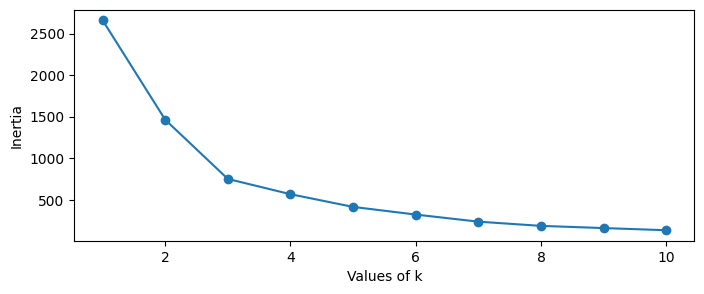


Best k value is: 3


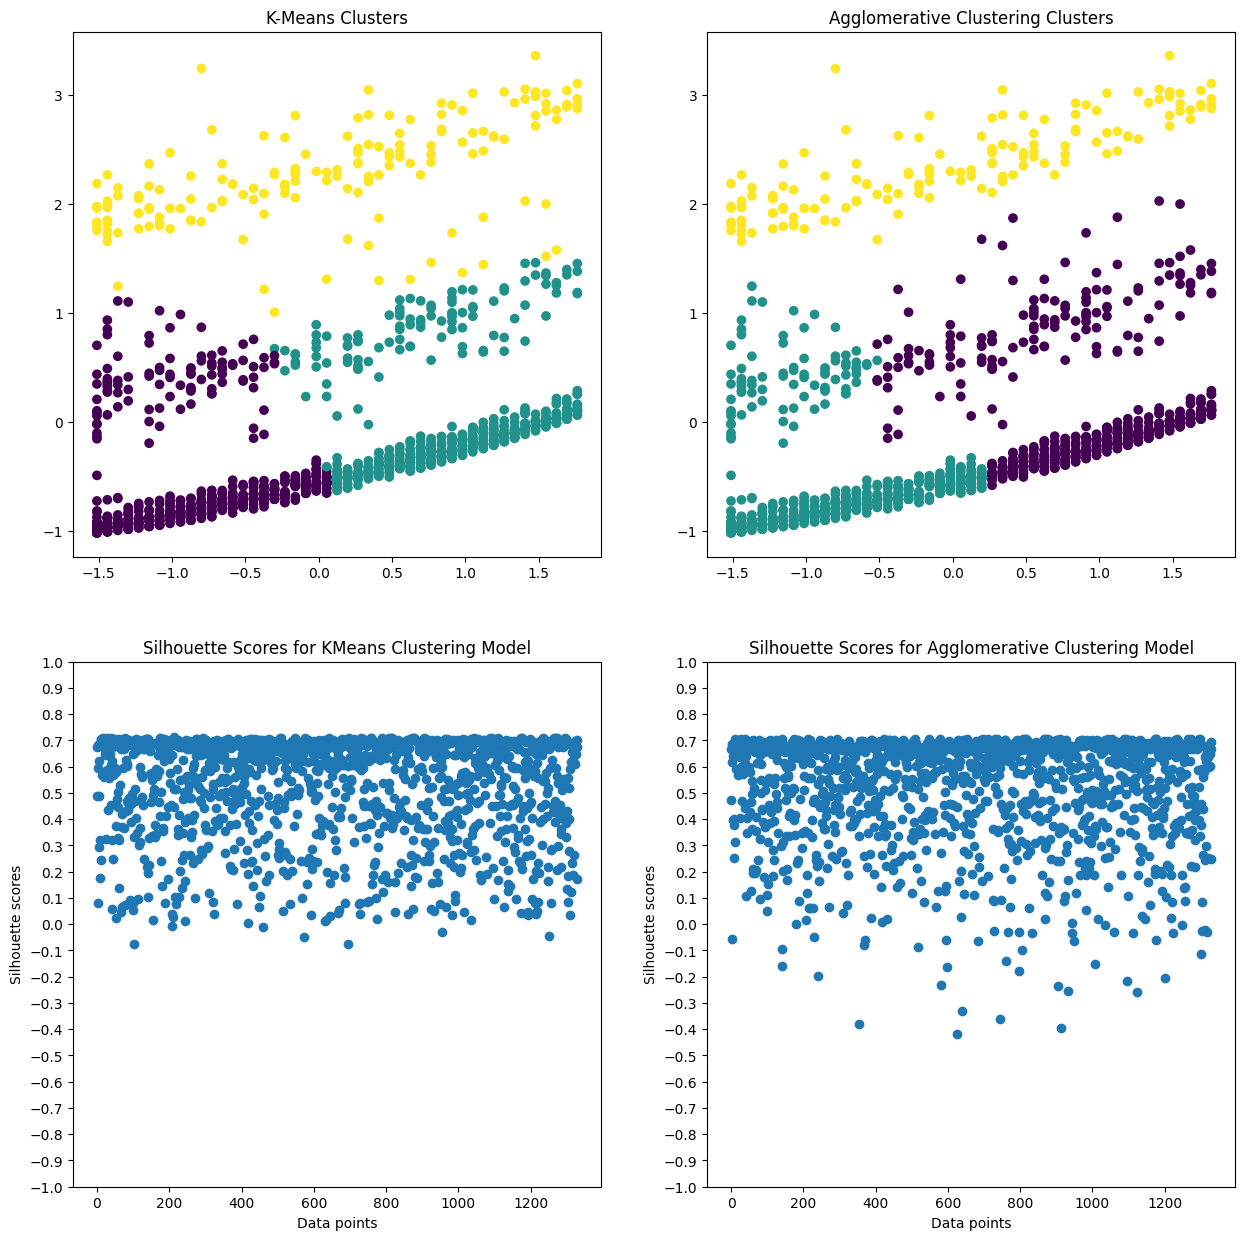

Average silhouette scores for both models:
KMeans Clustering Model: 0.522
Agglomerative Clustering Model: 0.509


In [8]:
clustering(scaled_df, 's_age', 's_charges')

Clusterings for **'sex'** and **'charges'** values

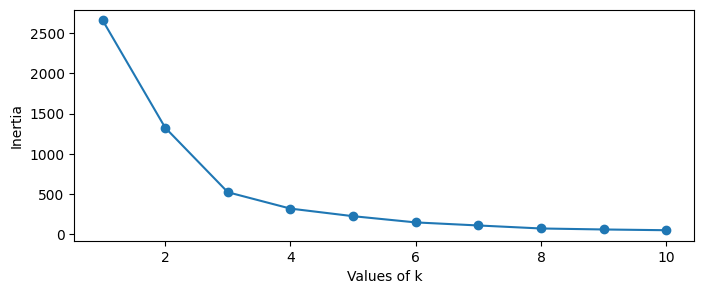


Best k value is: 3


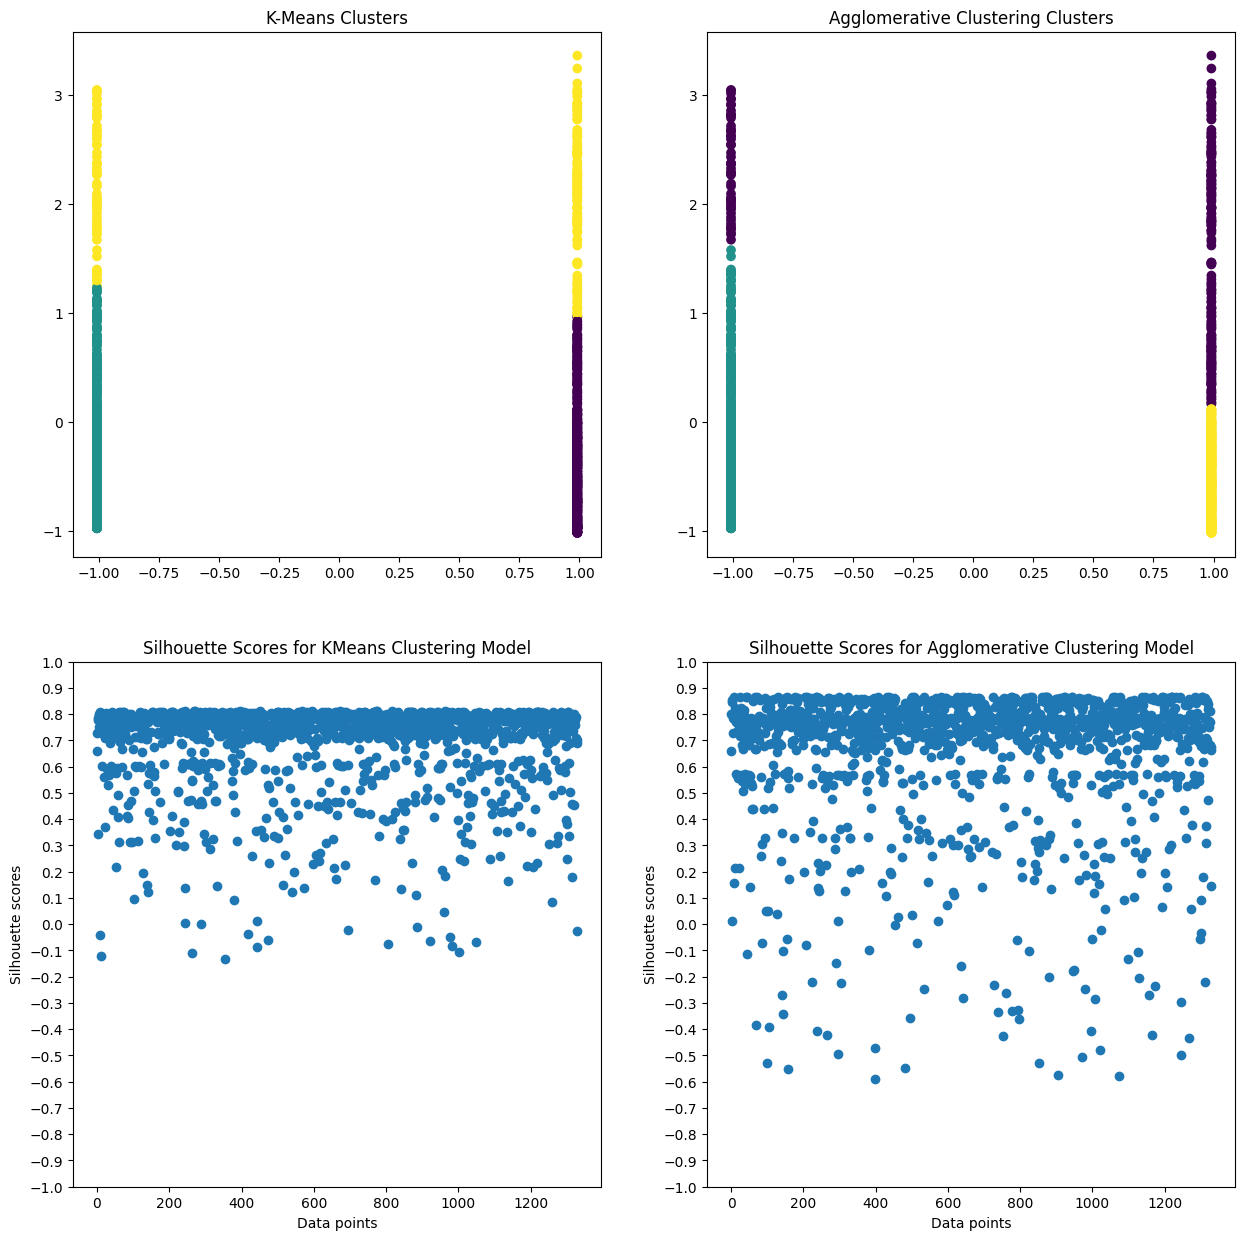

Average silhouette scores for both models:
KMeans Clustering Model: 0.685
Agglomerative Clustering Model: 0.6541


In [9]:
clustering(scaled_df, 's_sex', 's_charges')

Clusterings for **'bmi'** and **'charges'** values

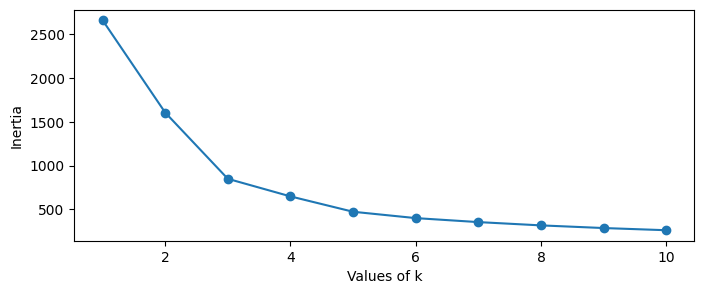


Best k value is: 3


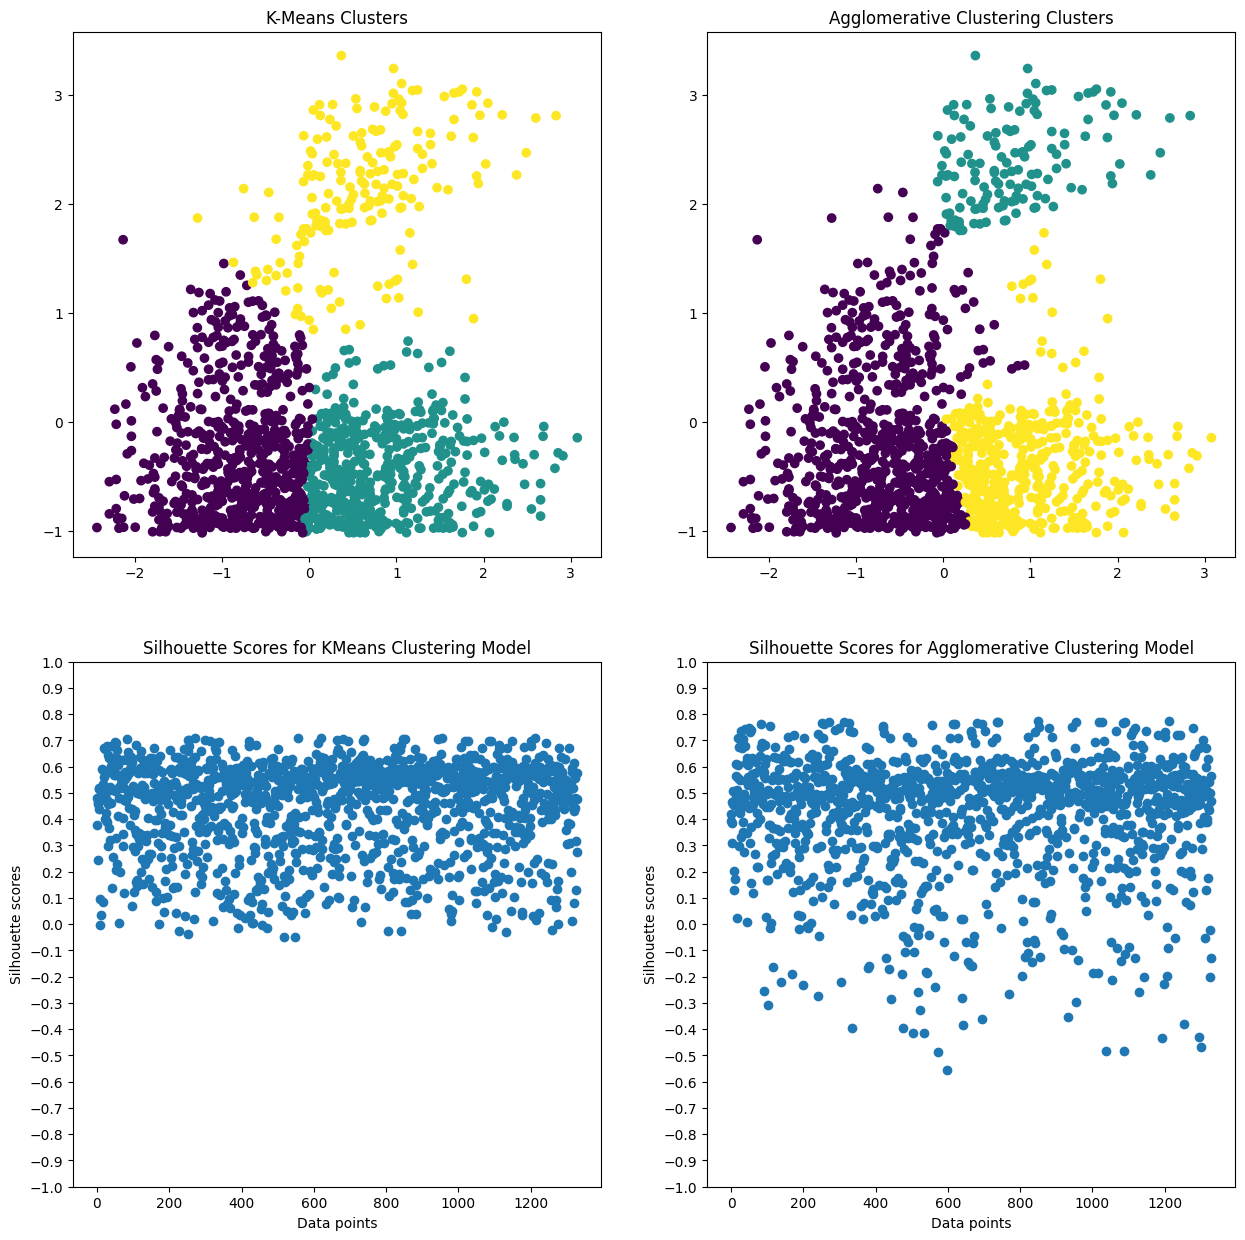

Average silhouette scores for both models:
KMeans Clustering Model: 0.4435
Agglomerative Clustering Model: 0.4156


In [10]:
clustering(scaled_df, 's_bmi', 's_charges')

Clusterings for **'children'** and **'charges'** values

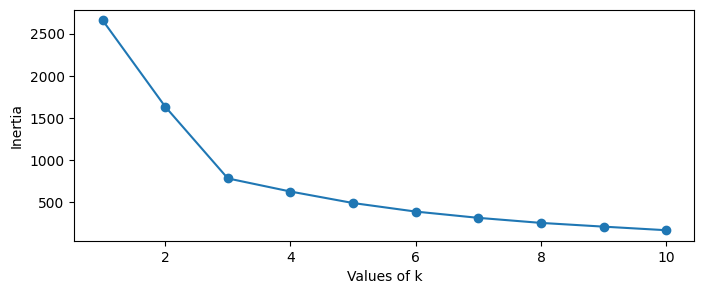


Best k value is: 3


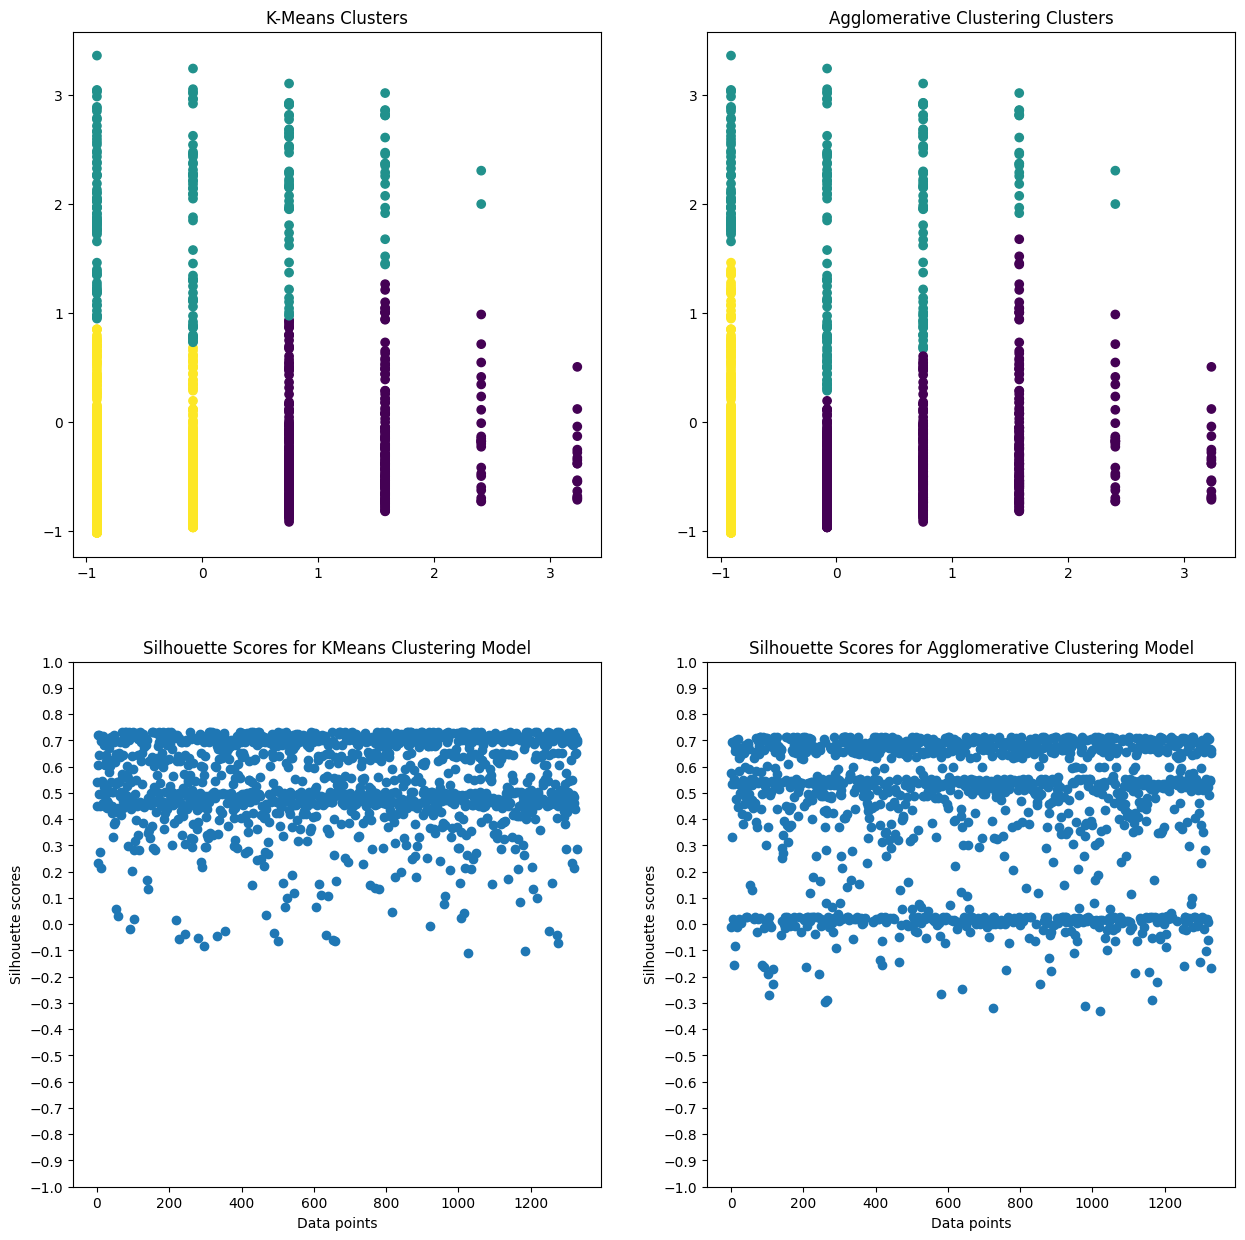

Average silhouette scores for both models:
KMeans Clustering Model: 0.5373
Agglomerative Clustering Model: 0.4267


In [11]:
clustering(scaled_df, 's_children', 's_charges')

Clusterings for **'region'** and **'charges'** values

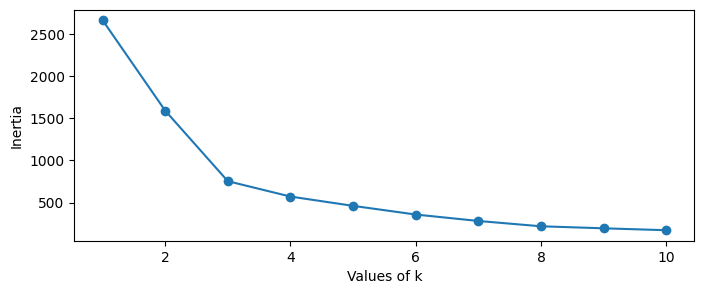


Best k value is: 3


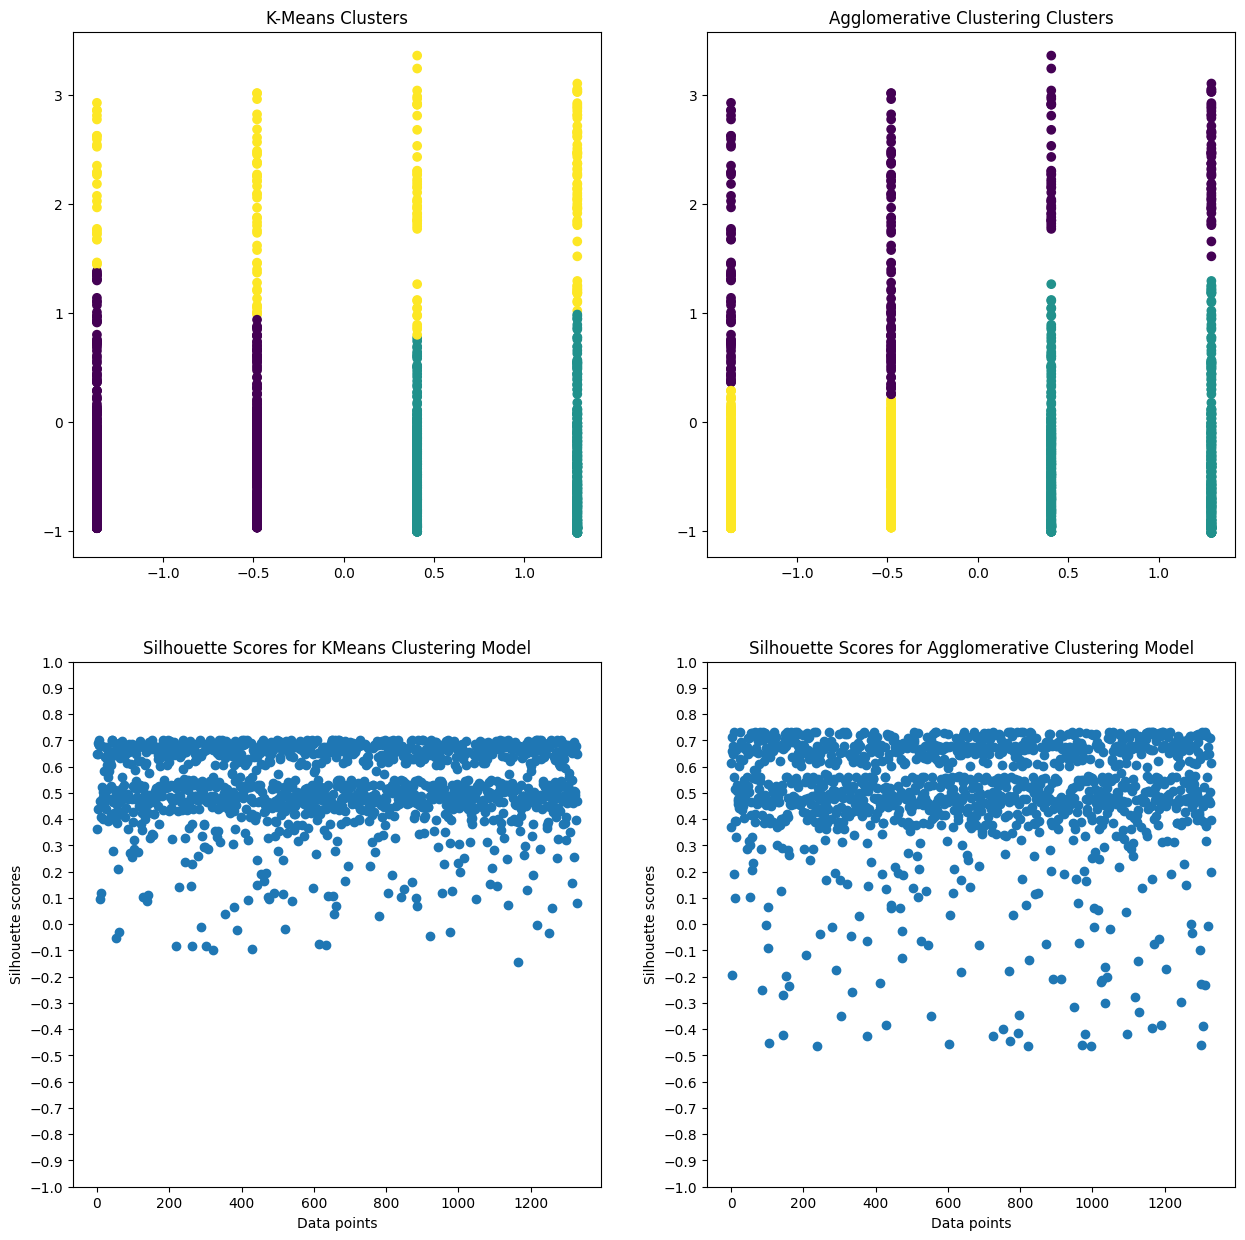

Average silhouette scores for both models:
KMeans Clustering Model: 0.524
Agglomerative Clustering Model: 0.4934


In [12]:
clustering(scaled_df, 's_region', 's_charges')

If I comment on the results, I can say k-means algorithm is better than agglomerative clustering algorithm in this dataset.
In the scatter plots that show clusters, we can see a little bit better clusterings in k-means than the agglomerative's.
If we analyze silhouette scores, it will say same thing. Even if agglomerative clustering algorithm's max silhouette scores is slightly greater than k-means, there is a lot of negative scores in agglomerative algorithm when k-means has just a few. So average scores of k-means model is always higher than agglomerative model in these clusterings. 